# 15wk-1: (강화학습) – LunarLander

## 1. Imports

In [1]:
import gymnasium as gym
#--#
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import IPython
#--#
import collections
import random
#--#
import torch

In [2]:
def show(imgs,jump=10):
    imgs = imgs[::jump]
    fig = plt.Figure()
    ax = fig.subplots()
    def update(i):
        ax.imshow(imgs[i])
    ani = FuncAnimation(fig,update,frames=len(imgs))
    display(IPython.display.HTML(ani.to_jshtml()))

## 2. 주요 코드 등

## 3. 예비학습

`-` `random.sample()`

`# 예시1`

In [3]:
random.sample([1, 2, 3, 4, 5], 2)

[1, 4]

`# 예시2`

In [4]:
s = [[0, 0], [0, 2], [3, 2]]
a = [0, 1, 2]
memory = list(zip(s, a))
random.sample(memory, 2)

[([0, 2], 1), ([0, 0], 0)]

## 4. env: LunarLander

`-` ref: <https://gymnasium.farama.org/environments/box2d/lunar_lander/>

`-` Lunar Lander 요약

**Observation Space (State Space) - 8개의 변수**

1.  착륙선의 x 좌표
2.  착륙선의 y 좌표
3.  착륙선의 x 속도
4.  착륙선의 y 속도
5.  착륙선의 각도
6.  착륙선의 각속도
7.  왼쪽 다리가 땅에 닿아있는지 여부 (1 또는 0)
8.  오른쪽 다리가 땅에 닿아있는지 여부 (1 또는 0)

**Action Space** – 4개의 변수

1.  {0 : 아무 행동도 하지 않음}
2.  {1 : 왼쪽 엔진 발사 (오른쪽으로 기울임)}
3.  {2 : 메인 엔진 발사 (위로 밀어 올림)}
4.  {3 : 오른쪽 엔진 발사 (왼쪽으로 기울임)}

**Reward**

-   **거리 보상**: 착륙 패드에 가까울수록 보상 증가
-   **속도 보상**: 속도가 낮을수록 보상 증가
-   **각도 보상**: 각도가 수직에 가까울수록 보상 증가
-   **착륙 다리 보상**: 다리가 착륙 패드에 닿으면 보상
-   **연료 사용 패널티**: 엔진 사용 시 패널티
-   **안전한 착륙 보상**: 안정적으로 착륙 시 큰 보상 (+100~+140)
-   **충돌 패널티**: 착륙 패드 이외의 장소에 충돌 시 패널티 (-100)

`-` 환경생성

In [5]:
env = gym.make("LunarLander-v3", render_mode = "rgb_array")
env

<frozen importlib._bootstrap>:228: RuntimeWarning: Your system is avx2 capable but pygame was not built with support for it. The performance of some of your blits could be adversely affected. Consider enabling compile time detection with environment variables like PYGAME_DETECT_AVX2=1 if you are compiling without cross compilation.


<TimeLimit<OrderEnforcing<PassiveEnvChecker<LunarLander<LunarLander-v3>>>>>

`-` state_space

In [6]:
env.observation_space ## min / max

Box([ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ], [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ], (8,), float32)

In [7]:
env.observation_space.sample()

array([-2.416511  ,  1.450472  , -6.5656524 , -4.313337  , -5.037138  ,
       -1.852658  ,  0.57062024,  0.70804536], dtype=float32)

* 8개의 숫자가 포함된 array가 나옴
* 해당 8개의 숫자는 각각의 상태 -> state를 의미함

`-` `action_space`

In [8]:
env.action_space.sample()

np.int64(0)

* 0, 1, 2, 3 중 하나가 랜덤으로 뽑힘

`-` `env.reset()`

In [9]:
env.reset() ## 말그대로 리셋

(array([ 4.6987535e-04,  1.4169807e+00,  4.7572572e-02,  2.6936159e-01,
        -5.3762598e-04, -1.0775863e-02,  0.0000000e+00,  0.0000000e+00],
       dtype=float32),
 {})

> default state와 info

`-` `env.render()`

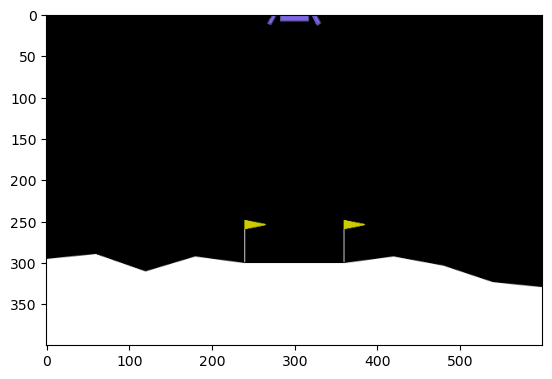

In [10]:
plt.imshow(env.render());

In [11]:
env.render().shape

(400, 600, 3)

> 현 상태를 나타내는 이미지 텐서. hwc

`-` `env.step`

In [12]:
env.step??

Signature: env.step(action: 'ActType') -> 'tuple[ObsType, SupportsFloat, bool, bool, dict[str, Any]]'
Source:   
    def step(
        self, action: ActType
    ) -> tuple[ObsType, SupportsFloat, bool, bool, dict[str, Any]]:
        """Steps through the environment and if the number of steps elapsed exceeds ``max_episode_steps`` then truncate.

        Args:
            action: The environment step action

        Returns:
            The environment step ``(observation, reward, terminated, truncated, info)`` with `truncated=True`
            if the number of steps elapsed >= max episode steps

        """
        observation, reward, terminated, truncated, info = self.env.step(action)
        self._elapsed_steps += 1

        if self._elapsed_steps >= self._max_episode_steps:
            truncated = True

        return observation, reward, terminated, truncated, info
File:      ~/anaconda3/envs/dl/lib/python3.9/site-packages/gymnasium/wrappers/common.py
Type:      method

* 리턴되는 값은 `observation`(state), `reward`, `terminated`, `truncated`, `info`
* 우리가 쓰는 값은 `observation`, `reward`, `terminated`, `truncated`

> `truncated` : 떨어지면 점수가 많이 깎임 -> 계속 떠있으려 함 -> 프레임 제한을 걸어버림

* 정상적으로 플레이하다가 clear -> terminated = True, truncated = False
* 정상적으로 플레이하다가 die -> terminated = True, truncated = False
* **정상적으로 플레이하다가 timeout -> terminated = False, truncated = True**
* `into`는 여기선 없음. 그냥 없음. 더미임.

### **Play**

*첫시작화면*

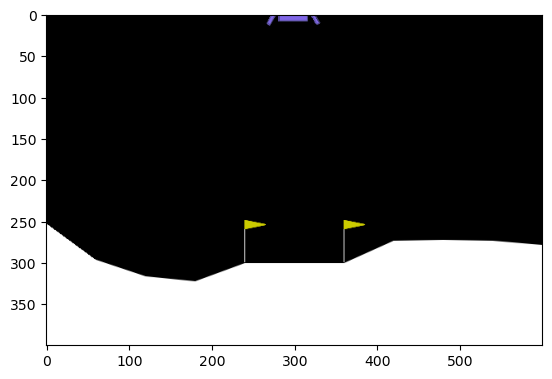

In [13]:
env.reset()
plt.imshow(env.render());

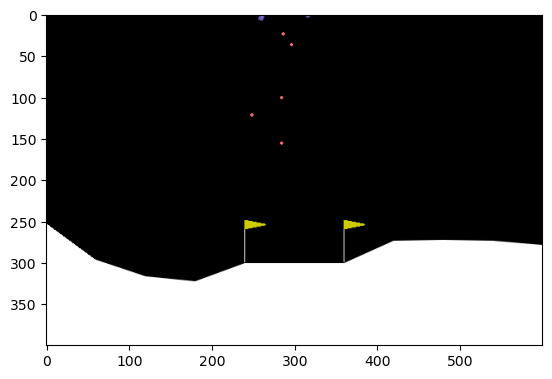

In [14]:
for _ in range(5) :
    ## 쏘다가 안쏘다가 쏘다가 안쏘다가...
    env.step(0)
    env.step(2)

plt.imshow(env.render());

## 5. 시각화

In [15]:
state, _ = env.reset()
imgs = []

for t in range(500) :
    action = env.action_space.sample()
    next_state, reward, terminated, truncated, _ = env.step(action)
    imgs.append(env.render())
    state = next_state

    if terminated or truncated :
        break

In [16]:
show(imgs)

## 6. `RandomAgent`

In [17]:
class RandomAgent :
    def __init__(self) :
        self.state = None
        self.action = None
        self.reward = None
        self.next_state = None
        self.terminated = None
        # self.truncated = None ## 얜 필요 없음??

        self.states = collections.deque(maxlen = 5000)
        self.actions = collections.deque(maxlen = 5000)
        self.rewards = collections.deque(maxlen = 5000)
        self.next_states = collections.deque(maxlen = 5000)
        self.terminations = collections.deque(maxlen = 5000)
        # self.truncations = collections.deque(maxlen = 5000) ## state에 들어가 있어서 학습에 영향 X긴 한데, 그럼 terminations도...

        self.action_space = gym.spaces.Discrete(4) ## env에도 있으나, 간단하므로 만듦
        self.n_experiences = 0

    def act(self) :
        self.action = self.action_space.sample()

    def save_experience(self) :
        self.states.append(torch.tensor(self.state)) ## Pytorch 네트워크에 입력값으로 들어감
        self.actions.append(self.action)
        self.rewards.append(self.reward)
        self.next_states.append(torch.tensor(self.next_state))
        self.terminations.append(self.terminated)

        self.n_experiences += 1

    def learn(self) :
        pass

In [18]:
env = gym.make("LunarLander-v3", render_mode = "rgb_array")
player = RandomAgent()
player.state, _ = env.reset()

for e in range(1, 101) :
    while True :
        player.act()
        player.next_state, player.reward, player.terminated, player.truncated, _ = env.step(player.action)
        player.save_experience()
        player.learn()

        if player.terminated or player.truncated :
            player.state, _ = env.reset()
            break
        else :
            player.state = player.next_state

## 7. `q_net`

`-` 4x4 Grid

* `q_table[s1, s2]` : [행동 0을 했을때 품질, 행동 1을 했을때 품질, 행동 2를 했을때 품질, 행동 3을 했을때 품질]
* `action` : `q_table[s1, s2].argmax()`

`-` LunarLander

* `q_net[states]` : [행동 0을 했을때 품질, 행동 1을 했을때 품질, 행동 2를 했을때 품질, 행동 3을 했을때 품질]
* `action` : `q_net[states].argmax()`

> 똑같은 역할을 수행할 수 있는 `q_net`만 만들어주면 됨.

`-` 전략 : 4x4에서는 `q_table`에 대응하는 뭔가가 있으면 됨. 근데 `q_table`과 같은 형식으로는 힘듦 -> `q_net`을 만들자.

* 4x4 Grid : 상태공간의 차원은 2차원이며, 가질 수 있는 값은 16개, 각 상태공간에서 가능한 행동이 4개 -> 총 16*4의 경우의 수에 대한 reward만 조사하면 되었음
* LunarLander : 상태공간의 차원은 8차원이지만 가질 수 있는 값은 실수 범위 -> 무수히 많은 경우에 대한 reward 값을 조사하는 건 현실적으로 불가능

*1개의 상황*

In [19]:
state = player.states[100]
action = player.actions[100]
reward = player.rewards[100]
next_state = player.next_states[100]
terminated = player.terminations[100]

`1`. `q_net`

In [20]:
player.q_net = torch.nn.Sequential(
    torch.nn.Linear(8, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 4)
)

In [21]:
player.q_net(state)

tensor([-0.0352, -0.0025,  0.0152,  0.0095], grad_fn=<ViewBackward0>)

`2`. `q_hat`

In [22]:
q_hat = player.q_net(state)[action]

`3`. `q` ($q = r + 0.99 \times \text{future}$)

In [23]:
if terminated :
    q = reward
else :
    future = player.q_net(next_state).max().data ## q : given
    q = reward + 0.99*future

> `q_hat` $\approx$ `q` -> 여기서 `q`는 주어진 값이여야 하는데... 그런건 없음
>
> `q`를 그냥 given target으로 보고, 스칼라로 받아들여야 함 -> 데이터만 사용

`4`. `q_hat`을 점점 `q`와 비슷하게 만드는 과정 == `player.q_net`을 학습하는 과정

* `loss = (q_hat - q)**2`
* `loss`를 점점 줄이면 됨

In [24]:
player.optimizr = torch.optim.Adam(player.q_net.parameters())

for epoc in range(5) :
    memory = list(zip(player.states, player.actions, player.rewards, player.next_states, player.terminations))
    mini_batch = random.sample(memory, 64)

    ## step 1-2
    loss = 0
    
    for s, a, r, ss, tmd in mini_batch :
        q_hat = player.q_net(s)[a]
        
        if tmd :
            q = r
        else :
            future = player.q_net(ss).max().data
            q = r + 0.99*future
            
        loss += (q_hat-q)**2
    
    loss = loss/64

    ## step 3
    loss.backward()

    ## step 4
    player.optimizr.step()
    player.optimizr.zero_grad()

* 저장되어있는 모든 경험을 반영할 필요는 없음

> 여러 경험이 있는데, 저장된 것을 자꾸 업데이트하면 매 episode마다 기존에 학습했던 것을 또 학습에 사용하게 됨.
>
> 랜덤으로 이를 반영하게 하면 학습 데이터가 계속 바뀌는 트릭

`5`. 행동...?

* 기존 방식
1. 특정 시점 이전에는 계속 랜덤 액션
2. 특정 시점 이후에는 계속 q_table에서 도출되는 행동만 실행

---

* 이제 해볼 방식
1. 처음에는 랜덤 액션
2. 점차 에피소드가 지날수록 q_net에 근거한 행동을 더 많이 실행

In [25]:
player.q_net(s).argmax().item()

2

In [26]:
player.action_space.sample()

np.int64(0)

In [27]:
player.eps = 0.5

if random.random() < player.eps :
    action = player.action_space.sample()
else :
    state = torch.tensor(player.state)
    action = player.q_net(state).argmax().item()

## 에피소드가 지날수록 랜덤액션할 확률을 더 낮게
player.eps = player.eps * 0.995

## 8. Agent

In [33]:
class Agent(RandomAgent) :
    def __init__(self) :
        super().__init__()

        self.q_net = torch.nn.Sequential(
            torch.nn.Linear(8, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 4)
        )
        self.optimizr = torch.optim.Adam(self.q_net.parameters())
        self.eps = 1.0

    def act(self) :
        if random.random() < self.eps :
            self.action = self.action_space.sample()
        else :
            state = torch.tensor(self.state)
            self.action = self.q_net(state).argmax().item()
            
    def learn(self) :
        if self.n_experiences > 64 :
            for epoc in range(1) :
                memory = list(zip(self.states, self.actions, self.rewards, self.next_states, self.terminations))
                mini_batch = random.sample(memory, 64)
            
                ## step 1-2
                loss = 0
                
                for s, a, r, ss, tmd in mini_batch :
                    q_hat = self.q_net(s)[a]
                    
                    if tmd :
                        q = r
                    else :
                        future = self.q_net(ss).max().data
                        q = r + 0.99*future
                        
                    loss += (q_hat-q)**2
                
                loss = loss/64
            
                ## step 3
                loss.backward()
            
                ## step 4
                self.optimizr.step()
                self.optimizr.zero_grad()

## 9. Solve

In [51]:
env = gym.make("LunarLander-v3", render_mode = "rgb_array")
player = Agent()
player.state, _ = env.reset()
score = 0
playtime = 0
scores = []
playtimes = []

In [52]:
for e in range(1, 2001) :
    ##-----에피소드 시작-----##
    while True :
        ## step 1
        player.act()
        ## step 2
        player.next_state, player.reward, player.terminated, player.truncated, _ = env.step(player.action)
        ## step 3
        player.save_experience()
        player.learn()
        ## step 4
        score += player.reward
        
        if player.terminated or player.truncated :
            scores.append(score)
            playtimes.append(playtime)
            score = 0
            playtime = 0
            player.state, _ = env.reset()
            break

        else :
            playtime += 1
            player.state = player.next_state

    ##-----에피소드 끝-----##
    player.eps = player.eps * 0.995
    if (e % 50) == 0 :
        print(
            f"에피소드: {e}\t",
            f"경험: {player.n_experiences}\t",
            f"점수(평균): {np.mean(scores[-100:]):.2f}\t",
            f"게임시간(평균): {np.mean(playtimes[-100:]):.2f}\t",
            f"돌발행동: {player.eps:.2f}\t",
        )

    if np.mean(scores[-100:]) > 200:
        print("--루나랜더 클리어(2025.06.14.)--")
        break

에피소드: 50	 경험: 5004	 점수(평균): -141.39	 게임시간(평균): 99.08	 돌발행동: 0.78	
에피소드: 100	 경험: 11199	 점수(평균): -120.31	 게임시간(평균): 110.99	 돌발행동: 0.61	
에피소드: 150	 경험: 18432	 점수(평균): -71.55	 게임시간(평균): 133.28	 돌발행동: 0.47	
에피소드: 200	 경험: 33483	 점수(평균): -28.05	 게임시간(평균): 221.84	 돌발행동: 0.37	
에피소드: 250	 경험: 54163	 점수(평균): -2.20	 게임시간(평균): 356.31	 돌발행동: 0.29	
에피소드: 300	 경험: 75470	 점수(평균): -66.19	 게임시간(평균): 418.87	 돌발행동: 0.22	
에피소드: 350	 경험: 96547	 점수(평균): -163.38	 게임시간(평균): 422.84	 돌발행동: 0.17	
에피소드: 400	 경험: 107130	 점수(평균): -375.48	 게임시간(평균): 315.60	 돌발행동: 0.13	
에피소드: 450	 경험: 113738	 점수(평균): -410.34	 게임시간(평균): 170.91	 돌발행동: 0.10	
에피소드: 500	 경험: 123392	 점수(평균): -372.63	 게임시간(평균): 161.62	 돌발행동: 0.08	
에피소드: 550	 경험: 129058	 점수(평균): -595.10	 게임시간(평균): 152.20	 돌발행동: 0.06	
에피소드: 600	 경험: 134861	 점수(평균): -677.15	 게임시간(평균): 113.69	 돌발행동: 0.05	


KeyboardInterrupt: 

> 아주 오래 걸리기 때문에... 배치를 쓰면 참 좋을 것 같은데... -> 거의 네시간 정도 걸릴듯?
>
> 아니 왜이러노, 점수가 ㅈㄴ 불안정하게 튀네 -> 원래 이런건지, 아니면 그냥 코드가 잘못된건지...

In [48]:
player.eps = 0

while True:
    player.act()
    player.next_state, player.reward, player.terminated, player.truncated, _ = env.step(player.action)
    imgs.append(env.render())
    if player.terminated or player.truncated:
        break
    else:
        player.state = player.next_state

`-` 교수님이 뽑아놓은 가중치 먹이기

In [ ]:
!wget https://github.com/guebin/DL2025/raw/main/posts/q_net.pth

In [ ]:
player_dummy = Agent()
player_dummy.q_net.load_state_dict(
    torch.load("q_net.pth")
)
player_dummy.state, _ = env.reset()
imgs = []

In [ ]:
player_dummy.eps = 0 
while True:
    player_dummy.act()
    player_dummy.next_state, player_dummy.reward, player_dummy.terminated, player_dummy.truncated, _ = env.step(player_dummy.action)
    imgs.append(env.render())
    if player_dummy.terminated or player_dummy.truncated:
        break
    else:
        player_dummy.state = player_dummy.next_state

> 안정적인 학습을 위해서는 복잡한 테크닉을 사용해야 합니다... 시간상 안할겁니다...